<a href="https://colab.research.google.com/github/ChinaYiqun/AI-yanxishe/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

数据下载

In [ ]:
!wget http://qavs3w9z3.bkt.clouddn.com/yanxishe_74.zip
!unzip yanxishe_74.zip
!clear

In [2]:
import os
from sklearn.utils import shuffle
import pandas as pd
import shutil
!pip install efficientnet
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import efficientnet.keras as efn 
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from time import time
import os
from keras.preprocessing.image import ImageDataGenerator

TensorFlow 1.x selected.
Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


数据概览

In [3]:
df = pd.read_csv('train.csv')
df.head(5)

,id,gender,masterCategory,Sports
0,0,Men,Apparel,Casual
1,1,Men,Apparel,Casual
2,2,Men,Accessories,Casual
3,3,Men,Footwear,Sports
4,4,Women,Accessories,Casual


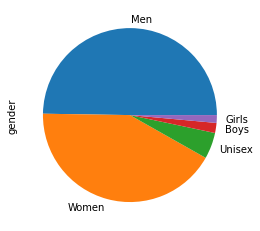

In [4]:
df['gender'].value_counts().plot.pie()

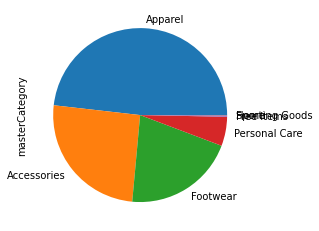

In [5]:
df['masterCategory'].value_counts().plot.pie()

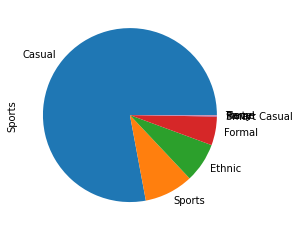

In [6]:
df['Sports'].value_counts().plot.pie()

预处理

In [7]:
dataset = df[~df.isnull().any(axis=1)]
dataset = shuffle(dataset)
train_tags = dataset.iloc[500:,:]
val_tags = dataset.iloc[:500,:]
val_tags

,id,gender,masterCategory,Sports
36160,36160,Women,Accessories,Casual
4840,4840,Unisex,Accessories,Casual
12570,12570,Women,Personal Care,Casual
25351,25351,Boys,Apparel,Casual
25611,25611,Men,Apparel,Casual
...,...,...,...,...
19032,19032,Men,Footwear,Sports
31230,31230,Women,Apparel,Ethnic
38439,38439,Men,Accessories,Casual
15207,15207,Men,Apparel,Casual


In [8]:
ca = set(df.columns)-{'id'}
for c in ca:
  os.mkdir(c)
  for ci in df['gender'].value_counts().index:
    os.mkdir(c+'/'+ci)

创建训练集 验证集

In [9]:
ca = set(df.columns)-{'id'}
for c in ca:
  os.mkdir('val_'+c)
  for ci in df['gender'].value_counts().index:
    os.mkdir('val_'+c+'/'+ci)

In [10]:
# val创建
for index,row in val_tags.iterrows():
  id = row['id']
  gender = row['gender']
  # masterCategory = row['masterCategory']
  # Sports = row['Sports']
  pc = 'train_new/'+str(id)+'.jpg'
  pv = 'val_gender/'+gender +'/'+ str(id)+'.jpg'
  shutil.copy(pc,pv)

In [11]:
# train 创建
for index,row in train_tags.iterrows():
  id = row['id']
  gender = row['gender']
  # masterCategory = row['masterCategory']
  # Sports = row['Sports']
  pc = 'train_new/'+str(id)+'.jpg'
  pv = 'gender/'+gender +'/'+ str(id)+'.jpg'
  shutil.copy(pc,pv)

In [12]:
conv_base = efn.EfficientNetB3(weights='imagenet',include_top=False,input_shape=(300, 300, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
44113920/44107200 [==============================] - 1s 0us/step


训练的参数

In [13]:
NUM_CLASSES = 5
BASE_DIR = ('./')
SIZES = {'basic': 300}
height = SIZES['basic']
width = height
STEPS_PER_EPOCH = 100
TOTAL_EPOCHS = 1
GENERATOR_BATCH_SIZE = 40

一些工具函数

In [14]:
# Slow down training deeper into dataset
def schedule(epoch):
    if epoch < 100:
        # Warmup model first
        return .0000032
    elif epoch < 12:
        return .01
    elif epoch < 20:
        return .002
    elif epoch < 30:
        return .001
    elif epoch < 40:
        return .0004
    elif epoch < 60:
        return .00008
    elif epoch < 80:
        return .000016
    elif epoch < 95:
        return .0000032        
    else:
        return .0000009    
def make_callbacks(weights_file):
    # checkpoint
    filepath = weights_file
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    # Update info
    tensorboard = TensorBoard(log_dir="log/{}".format(time()))

    # learning rate schedule
    lr_scheduler = LearningRateScheduler(schedule)

    # all the goodies
    return [lr_scheduler, checkpoint, tensorboard]
## callbacks_list = make_callbacks(weights_file)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    shear_range=0.5,
    zoom_range=0.3,
    fill_mode='wrap',
    width_shift_range=0.2,
    height_shift_range=0.2,
)

# Validation data should not be modified
validation_datagen = ImageDataGenerator(
    rescale=1./255
)
train_dir = os.path.join(BASE_DIR, 'gender')
test_dir = os.path.join(BASE_DIR, 'val_gender')
def create_generators(height, width):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        class_mode='categorical',
        batch_size=GENERATOR_BATCH_SIZE
    )

    validation_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        class_mode='categorical',
        batch_size=GENERATOR_BATCH_SIZE
    )

    return[train_generator, validation_generator]
def make_callbacks(weights_file):
    # checkpoint
    filepath = weights_file
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    # Update info
    tensorboard = TensorBoard(log_dir="log/{}".format(time()))

    # learning rate schedule
    lr_scheduler = LearningRateScheduler(schedule)

    # all the goodies
    return [lr_scheduler, checkpoint, tensorboard]
weights_file = 'checkpoint/best_weights.efficientnet-b3.hdf5'
callbacks_list = make_callbacks(weights_file)

载入模型

In [15]:
# First time run, no unlocking
conv_base.trainable = False
# Let's construct that top layer replacement
x = conv_base.output
x = Flatten()(x)
x = Dropout(0.25)(x)
predictions = Dense(NUM_CLASSES,  kernel_initializer="glorot_uniform", activation='softmax')(x)
print('Stacking New Layers')
model = Model(inputs = conv_base.input, outputs=predictions)

Stacking New Layers


模型编译

In [16]:
from keras.optimizers import SGD,Adam
print('Compile model')
# originally adam, but research says SGD with scheduler
opt = Adam(lr=0.01, amsgrad=True)
#opt = SGD(momentum=1,lr=1,nesterov=True) #,clipnorm=1. clipnorm=0.8
#opt = keras.optimizers.Adadelta( rho=0.95, epsilon=None, decay=0.0)
#opt = keras.optimizers.Nadam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
# lrate = 0.01 
# epoch = 10
# decay = lrate/epoch
# opt = SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Get training/validation data via generators
train_generator, validation_generator = create_generators(height, width)

Compile model
Found 39648 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


训练和保存

In [ ]:
print('Start training!')
history = model.fit_generator(
    train_generator,
    callbacks=callbacks_list,
    epochs=10,
    steps_per_epoch=STEPS_PER_EPOCH,
    shuffle=True,
    workers=4,
    use_multiprocessing=True,
    validation_data=validation_generator,
    validation_steps=50
)

# Save it for later
print('Saving Model')

model.save("gender-EfficientNetB3_size." + str(width) + "x" + str(height) + ".hdf5")

Start training!



Epoch 1/10
 42/100 [===========>..................] - ETA: 5:58 - loss: 1.8372 - accuracy: 0.3310